# Mimid :  Inferring Grammars from X86 Binaries

* Evaluation starts [here](#Evaluation)
  * The evaluation on specific subjects starts [here](#Subjects)
    * [Calculator](#Calculator)
    * [MJS](#MJS)
    * [Duktape](#Duktape)
    * [TinyC](#TinyC)
    * [CSV](#CSV)
    * [Lisp](#Lisp)
    * [Yxml](#Yxml)

In [1301]:
import fuzzingbook

## X86 Instruction

### Class Instruction

In [1302]:
class Instruction:
    def __init__(self, instr):
        self.symbol_name = None
        self.pointed_address = None
        self.dest_reg = None
        self.instr_type = None
        self._parse(instr)

In [1303]:
class Instruction(Instruction):
    def get_pointed_value(self, val):
        val = val.strip('%*')
        if val in REGISTERS:
            ptr_addr = gdb.execute('x/s $%s' % (val),
                                to_string=True).split(':')
            return ptr_addr[0]
        return val

In [1304]:
class Instruction(Instruction):
    def resolve_addressing_mode(self, instr):
        str0 = instr.split(',')
        if len(str0) > 2:
            if instr.startswith('%'):
                return '$%s' % (str0[0][1:])
            else:
                if instr.startswith('-') or instr.startswith('0x'):
                    d, rb = tuple(str0[0].split('(%'))
                    ri = str0[1][1:]
                    s = str0[2].strip(')')
                    return '$%s+%s+%s*$%s' % (rb, d, s, ri)

        src = str0[-1]
        if '(' not in src:
            if src[1:] in REGISTERS:

                return '$%s' % src[1:]
        else:
            if src.startswith('-'):
                displacement, rest = tuple(src.split('(%'))
                return '$%s%s' % (rest[:-1], displacement)
            elif src.startswith('(') and src.endswith(')'):
                return '$%s' % src[2: -1]
            else:
                displacement, rest = tuple(src.split('(%'))
                return '$%s+%s' % (rest[:-1], displacement)

In [1305]:
class Instruction(Instruction):
    def _parse(self, instr):
        instr_list = instr.split()
        instr_list.pop(0)

        self.current_address = instr_list[0]
        if "<" in instr_list[1]:
            instr_list.pop(1)
        self.instr_type = instr_list[1]

        if self.instr_type == CALL:
            self.pointed_address = self.get_pointed_value(instr_list[2])
            if len(instr_list) > 3:
                self.symbol_name = instr_list[-1]

        elif self.instr_type.startswith('mov') or self.instr_type == 'push' or \
            self.instr_type == 'pop':
            self.dest_reg = self.resolve_addressing_mode(instr_list[2])

### Extracting function names from binary

In [1306]:
INP_ARR = []
VAL_TUPLE = []

In [1307]:
def reset_helper():
    global INP_ARR 
    global VAL_TUPLE
    INP_ARR.clear()
    VAL_TUPLE.clear()

### Binary Miner

In [1308]:
class BinaryDebugger:
    def __init__(self, inp, binary, fn_list):
        self.inp = inp
        self.binary = binary
        self.functions = fn_list
        self._set_logger()
        self.tree = {}
        self.mid = None
        self.method_map, self.m_stack = {}, []

In [1309]:
class BinaryDebugger(BinaryDebugger):
    def break_at(self, address):
        gdb.execute("break *%s" % address)
    def finish(self):
        gdb.execute('finish')
    def get_instruction(self):
        return gdb.execute('x/i $rip', to_string=True)
    def nexti(self):
        gdb.execute('nexti')
    def resume(self):
        gdb.execute('continue')
    def run(self):
        gdb.execute('run')
    def step(self):
        gdb.execute('stepi')

In [1310]:
class BinaryDebugger(BinaryDebugger):
    def start_program(self):
        gdb.execute("set args '%s'" % self.inp)
        gdb.execute("file %s" % self.binary)

In [1311]:
class BinaryDebugger(BinaryDebugger):
    def _in_scope(self, instr, addr_range):
        s1, e1, s2, e2 = addr_range
        instr = instr.split()
        instr.pop(0)
        
        current_addr = instr[0].strip(':')
        hex_val = int(current_addr, 16)
        if hex_val in range(int(s1, 16), int(e1, 16)) or \
            hex_val in range(int(s2, 16), int(e2, 16)):
            return True
        else:
            return False

In [1312]:
class BinaryDebugger(BinaryDebugger):
    def _get_entry_address(self):
        self.start_program()
        self.run()

        info_file = gdb.execute('info file', to_string=True)
        entry = None
        
        for line in info_file.splitlines():
            if 'Entry point' in line:
                entry = line.split(':')[1]
                break
        return entry

In [1313]:
class BinaryDebugger(BinaryDebugger):
    def _set_logger(self):
        gdb.execute('set logging overwrite on')
        gdb.execute('set logging redirect on')
        gdb.execute('set logging on')

In [1314]:
class BinaryDebugger(BinaryDebugger):
    def _get_address_range(self):
        s1 = s2 = None
        e1 = e2 = None
        mappings = gdb.execute('info proc mappings', to_string=True)

        for i, line in enumerate(mappings.splitlines()):
            if i == 4:
                s1 = line.split()[0]
            elif i == 6:
                e1 = line.split()[1]
            elif i == 7:
                s2 = line.split()[0]
            elif i == 10:
                e2 = line.split()[1]
        return (s1, e1, s2, e2)

In [1315]:
class BinaryDebugger(BinaryDebugger):
    def _get_main_address(self):
        entry = self._get_entry_address()
        self.break_at(entry)
        gdb.execute('run')

        instr = []
        while True:
            next_i = self.get_instruction()
            if CALL in next_i:
                break
            instr.append(next_i)
            self.step()

        instr = instr[-1].split()
        if len(instr) == 6:
            s = instr[3]
        else:
            s = instr[4]

        reg = s[-3:]
        main_addr = gdb.execute('p/x $%s' % reg, to_string=True)
        main_addr = main_addr.partition("= ")
        main_addr = main_addr[-1]

        return main_addr

In [1316]:
class BinaryDebugger(BinaryDebugger):
    def _lookup_address(self, addr, symbol):
        addr = addr.rstrip("\n")
        if addr in self.functions.keys():
            return self.functions[addr]
        else:
            if symbol:
                s0 = symbol[1:-1].split('@')[0]
                return s0
            return None

In [1317]:
class BinaryDebugger(BinaryDebugger):
    def _init_methodMap_mtdStack(self, mname):
        self.method_map = {'0':[0, None, [1]], '1': [1, mname, []]}
        self.m_stack = ['0', '1']

In [1318]:
class BinaryDebugger(BinaryDebugger):
    def _init_result(self, inp, arg1):
        self.result = {'inputstr': inp,
                'arg': inp,
                'original': arg1,
                'comparisons': []}

In [2503]:
class BinaryDebugger(BinaryDebugger):
    def event_loop(self):
        main = self._get_main_address()
        mname = self._lookup_address(main, None)
        cs = CallStack()
        cs.enter(mname)

        self._init_methodMap_mtdStack(mname)     
        self._init_result(self.inp, arg1)  
        self.break_at(main)
        self.resume()
        addr_range = self._get_address_range()
        t = ['main']

        while True:
            try:
                nexti = self.get_instruction()
                if self._in_scope(nexti, addr_range):
                    h = Instruction(nexti)
                    if h.instr_type == CALL:
                        name = self._lookup_address(h.pointed_address, h.symbol_name)
                        if not name or name == 'exit':
                            self.step()
                            self.finish()
                        else:
                            self.step()
                            cs.enter(name)
                            x, self.mid = cs.method_id
                            self.method_map[self.m_stack[-1]][-1].append(self.mid)
                            self.method_map[str(self.mid)] = [self.mid, name, []]
                            self.m_stack.append(str(self.mid))
                    elif h.instr_type == RETURN:
                        self.step()
                        c = [i for i, s in enumerate(t) if s in nexti]
                        if c:
                            for x in range(c[-1], len(t)):
                                t.pop()
                                cs.leave()
                                if len(self.m_stack) > 1: self.m_stack.pop()
                        else:
                            t.pop()
                            cs.leave()
                            if len(self.m_stack) > 1: self.m_stack.pop()
                        self.mid = cs.method_id[1]
                    else:
                        self.step()
                        val = read_register_val(h.dest_reg, self.inp)
                        comparison = process_value(val, self.mid, self.inp)
                        if comparison != None:
                            self.result['comparisons'].extend(comparison)
                else:
                    self.finish()
            except gdb.error:
                break
        self.result['method_map'] = self.method_map
        with open('tree', 'w+') as f:
            obj = jsonpickle.encode(self.result)
            f.write(obj)

In [1320]:
from fuzzingbook import fuzzingbook_utils
import sys

In [1321]:
head = """\
import sys
sys.path.extend([%s])
sys.path.append('.')
import matplotlib.pyplot
matplotlib.pyplot._IP_REGISTERED = True # Hack
#import fuzzingbook_utils
import fuzzingbook
from fuzzingbook.GrammarMiner import CallStack
import jsonpickle
import os, subprocess
import gdb
import re, json
""" % (', '.join("'%s'" % str(i) for i in sys.path if i))
Instruction_src = fuzzingbook_utils.extract_class_definition(Instruction)
BinaryDebugger_src = fuzzingbook_utils.extract_class_definition(BinaryDebugger)

declaration = """
CALL = 'callq'
RETURN = 'retq'
LINE = 'line'
ARG_REGISTERS = ['rdi', 'rsi', 'rdx', 'rcx', 'r8', 'r9', 'edi', 'rbx']
REGISTERS = ARG_REGISTERS + ['rax', 'eax', 'edi' 'esi', 'edx', 'ecx', 'rsp', 'rbp']
"""
helper1 = """
INP_ARR = []
VAL_TUPLE = []

def reset_helper():
    global INP_ARR 
    global VAL_TUPLE
    INP_ARR.clear()
    VAL_TUPLE.clear()
    
def get_names_from_symbols(objfile):
    names = []
    for name in objfile:
        name = name.split()
        name = name[-1].decode('utf-8')
        if '@@' in name:
            names.append(name.split('@@')[0])
            continue
        names.append(name)
    return names

def list_objfile_symbols():
    proc = subprocess.Popen(['nm', 'a.out'], stdout=subprocess.PIPE)
    output = proc.stdout.read()
    output = output.splitlines()
    return output

def get_function_names(inp, binary):
    fn_dict = {}
    fn_names = []

    symbols = list_objfile_symbols()
    functions = get_names_from_symbols(symbols)

    gdb.execute("set args '%s'" % inp)
    gdb.execute("file %s" % binary)
    gdb.execute('set confirm off')
    gdb.execute('run')
    for k in functions:
        try:
            s = gdb.execute('info address %s' % k,
            to_string=True).split(' ')
            if s[4].startswith('0x'):
                v = s[4].rstrip()
                u = v.strip('.')
                fn_dict[v] = k
            else:
                u = s[-1].rstrip()
                u = u.strip('.')
                fn_dict[u] = k
        except gdb.error:
            continue
    return fn_dict
"""
helper2 = """
def read_register_val(reg, original):
    if not reg:
        return None

    val = read_as_string(reg)
    if not val or 'error' in val:
        return None
    elif val in original:
        return val
    else:
        val = val.strip('\t')
        x = val[1: -1] if val[0] == '"' and val[-1] == '"' else val
        return x if x in original else None

def read_ptr_addr(reg):
    try:
        str1 = gdb.execute('x/a %s' % (reg), to_string=True)
        for idx, char in enumerate(str1):
            if str1[idx] == ':':
                addr_val = str1[idx + 1:]
                addr_val = addr_val.strip()
                break
        return addr_val
    except Exception:
        return
        
def read_as_string(reg):
    try:
        str0 = gdb.execute('x/s %s' % (reg), to_string=True)
        if '<error:' in str0 and not reg.startswith('0x'):
            x = gdb.execute('p/c %s' % reg, to_string=True)
            x = x.split()
            x = x[-1]
            return x[1:-1]

        for idx, char in enumerate(str0):
            if str0[idx] == ':':
                str_val = str0[idx + 1:]
                str_val = str_val.strip()
                break
        return str_val
    except Exception:
        return

def process_value(val, mid, inputstr):
    if val and val != inputstr and mid:
        idx = inputstr.find(val)
        for idx in range(idx, idx + len(val)):
            return [[idx, inputstr[idx], mid]]
"""
tail = """
reset_helper()
arg_0 = None
with open(f'inp.0.txt', 'r+') as f:
    arg_0 = f.read().strip()

fnames = get_function_names(arg_0, "a.out")
subprocess.call(['strip', '-s', "a.out"])

debugger = BinaryDebugger(arg_0, 'a.out', fnames)
debugger.event_loop()
"""
miner_src = '\n'.join([head, declaration, Instruction_src, helper1, BinaryDebugger_src, helper2, tail])

In [1322]:
with open('x.py', 'w+') as f:
    print(miner_src, file=f)

## Generating Trace

Here is how one can generate traces for the `calc` program.

In [2471]:
inp = '(1+2)-3'
source = 'subject/calc/calc_parse.c'
#(1+2)-2

with open(f'inp.0.txt', 'w+') as f:
    print(inp, file=f)

In [2472]:
arg0 = '\'py arg0="%s"\'' % inp
arg1 = '\'py arg1="%s"\'' % source

!gcc -g {source}
!gdb --batch-silent -ex {arg0} -ex {arg1} -x bminer.py

In [2473]:
import jsonpickle
calc_trace = []
with open(f'tree', 'rb') as f:
    calc_trace.append((jsonpickle.decode(f.read())))

calc_trace

[{'inputstr': '(1+2)-3',
  'arg': '(1+2)-3',
  'original': 'subject/calc/calc_parse.c',
  'comparisons': [[0, '(', 2],
   [4, ')', 2],
   [4, ')', 8],
   [2, '+', 8],
   [1, '1', 8],
   [6, '3', 8],
   [4, ')', 22],
   [4, ')', 22],
   [1, '1', 24],
   [0, '(', 3],
   [1, '1', 31],
   [1, '1', 28],
   [1, '1', 34],
   [1, '1', 34],
   [1, '1', 34],
   [1, '1', 40],
   [1, '1', 41],
   [1, '1', 42],
   [1, '1', 42],
   [1, '1', 40],
   [1, '1', 40],
   [1, '1', 40],
   [1, '1', 34],
   [1, '1', 34],
   [1, '1', 28],
   [1, '1', 28],
   [2, '+', 28],
   [3, '2', 28],
   [3, '2', 48],
   [3, '2', 48],
   [3, '2', 48],
   [3, '2', 54],
   [3, '2', 55],
   [3, '2', 56],
   [3, '2', 56],
   [3, '2', 54],
   [3, '2', 54],
   [3, '2', 54],
   [3, '2', 48],
   [3, '2', 48],
   [3, '2', 28],
   [3, '2', 28],
   [1, '1', 3],
   [5, '-', 3],
   [6, '3', 3],
   [6, '3', 65],
   [6, '3', 65],
   [6, '3', 65],
   [6, '3', 71],
   [6, '3', 72],
   [6, '3', 73],
   [6, '3', 73],
   [6, '3', 71],
   [6,

## Mining the Traces Generated

### Reconstructing the Method Tree with Attached Character Comparisons

Reconstruct the actual method trace from a trace with the following
format
```
key   : [ mid, method_name, children_ids ]
```

In [2474]:
def reconstruct_method_tree(method_map):
    first_id = None
    tree_map = {}
    for key in method_map:
        m_id, m_name, m_children = method_map[key]
        children = []
        if m_id in tree_map:
            # just update the name and children
            assert not tree_map[m_id]
            tree_map[m_id]['id'] = m_id
            tree_map[m_id]['name'] = m_name
            tree_map[m_id]['indexes'] = []
            tree_map[m_id]['children'] = children
        else:
            assert first_id is None
            tree_map[m_id] = {'id': m_id, 'name': m_name, 'children': children, 'indexes': []}
            first_id = m_id

        for c in m_children:
            assert c not in tree_map
            val = {}
            tree_map[c] = val
            children.append(val)
    return first_id, tree_map

In [2475]:
from fuzzingbook.GrammarFuzzer import display_tree

In [2476]:
first, calc_method_tree = reconstruct_method_tree(calc_trace[0]['method_map'])

In [2477]:
def extract_node(node, id):
    symbol = str(node['id'])
    children = node['children']
    annotation = str(node['name'])
    return "%s:%s" % (symbol, annotation), children, ''

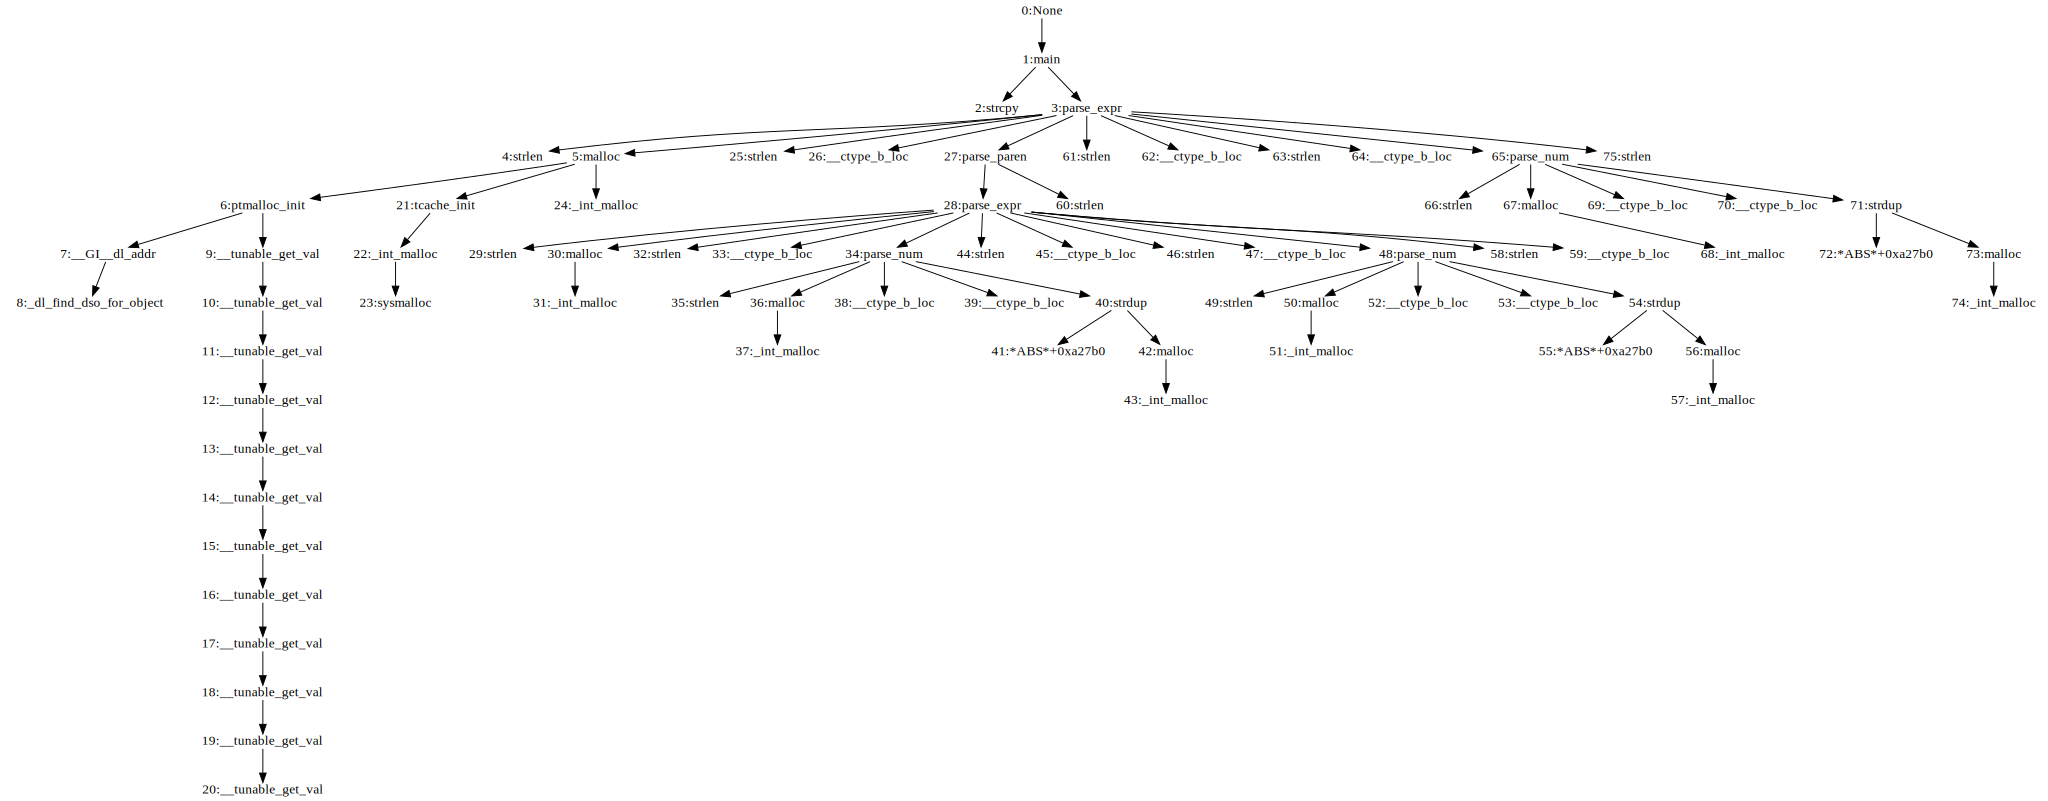

In [2478]:
display_tree(calc_method_tree[0], extract_node=extract_node)

#### Identifying last comparisons
We need only the last comparisons made on any index. This means that we should care for only the last parse in an ambiguous parse. So, we assign the method that last touched an index to be its consumer.

However, to make concessions for real world, we also check if we are overwriting a child (`HEURISTIC`). Essentially, if the heursitic is enabled, then if the current method id (`midP`) is smaller than the `midC` already stored in the last comparison map, then it means that `midP` is a parent that called `midC` previously, and now accessing an index that `midC` touched. This happens when the parent tries to find a substring like `#` in the entirety of the original string. (Note that we have seen this only in `URLParser`). (Note that this heuristic does not restrict reparsing by another function call -- in such a case, `midC` will not smaller than `midP`). So, perhaps, we should let the child keep the ownership. However, there is one more wrinkle. If the character being contested was the last index touched by our `mid`, then it is likely that it was simply a boundary check. In that case, we should let the parent own this character.

In [2479]:
LAST_COMPARISON_HEURISTIC = False

In [2480]:
def last_comparisons(comparisons):
    last_cmp_only = {}
    last_idx = {}

    # get the last indexes compared in methods.
    for idx, char, mid in comparisons:
        if mid in last_idx:
            if idx > last_idx[mid]:
                last_idx[mid] = idx
        else:
            last_idx[mid] = idx

    for idx, char, mid in comparisons:
        if LAST_COMPARISON_HEURISTIC:
            if idx in last_cmp_only:
                midC = last_cmp_only[idx]
                if midC > mid:
                    # midC is a child of mid.
                    # do not clobber children unless it was the last character
                    # for that child.
                    if last_idx[mid] == idx:
                        # if it was the last index, may be the child used it
                        # as a boundary check.
                        pass
                    else:
                        # do not overwrite the current value of `last_cmp_only[idx]`
                        continue
        last_cmp_only[idx] = mid
    return last_cmp_only

In [2481]:
calc_last_comparisons = last_comparisons(calc_trace[0]['comparisons'])

In [2482]:
calc_last_comparisons

{0: 3, 4: 22, 2: 28, 1: 3, 6: 3, 3: 28, 5: 3}

#### Attaching characters to the tree
Add the comparison indexes to the method tree that we constructed

In [2483]:
def attach_comparisons(method_tree, comparisons):
    for idx in comparisons:
        mid = comparisons[idx]
        method_tree[mid]['indexes'].append(idx)

In [2484]:
attach_comparisons(calc_method_tree, calc_last_comparisons)

In [2485]:
calc_method_tree

{0: {'id': 0,
  'name': None,
  'children': [{'id': 1,
    'name': 'main',
    'indexes': [],
    'children': [{'id': 2, 'name': 'strcpy', 'indexes': [], 'children': []},
     {'id': 3,
      'name': 'parse_expr',
      'indexes': [0, 1, 6, 5],
      'children': [{'id': 4, 'name': 'strlen', 'indexes': [], 'children': []},
       {'id': 5,
        'name': 'malloc',
        'indexes': [],
        'children': [{'id': 6,
          'name': 'ptmalloc_init',
          'indexes': [],
          'children': [{'id': 7,
            'name': '__GI__dl_addr',
            'indexes': [],
            'children': [{'id': 8,
              'name': '_dl_find_dso_for_object',
              'indexes': [],
              'children': []}]},
           {'id': 9,
            'name': '__tunable_get_val',
            'indexes': [],
            'children': [{'id': 10,
              'name': '__tunable_get_val',
              'indexes': [],
              'children': [{'id': 11,
                'name': '__tunable_get_va

In [2486]:
def wrap_input(istr):
    def extract_node(node, id):
        symbol = str(node['id'])
        children = node['children']
        annotation = str(node['name'])
        indexes = repr(tuple([istr[i] for i in node['indexes']]))
        return "%s %s" % (annotation, indexes), children, ''
    return extract_node

In [2487]:
extract_node1 = wrap_input(calc_trace[0]['inputstr'])

#### Tree 1

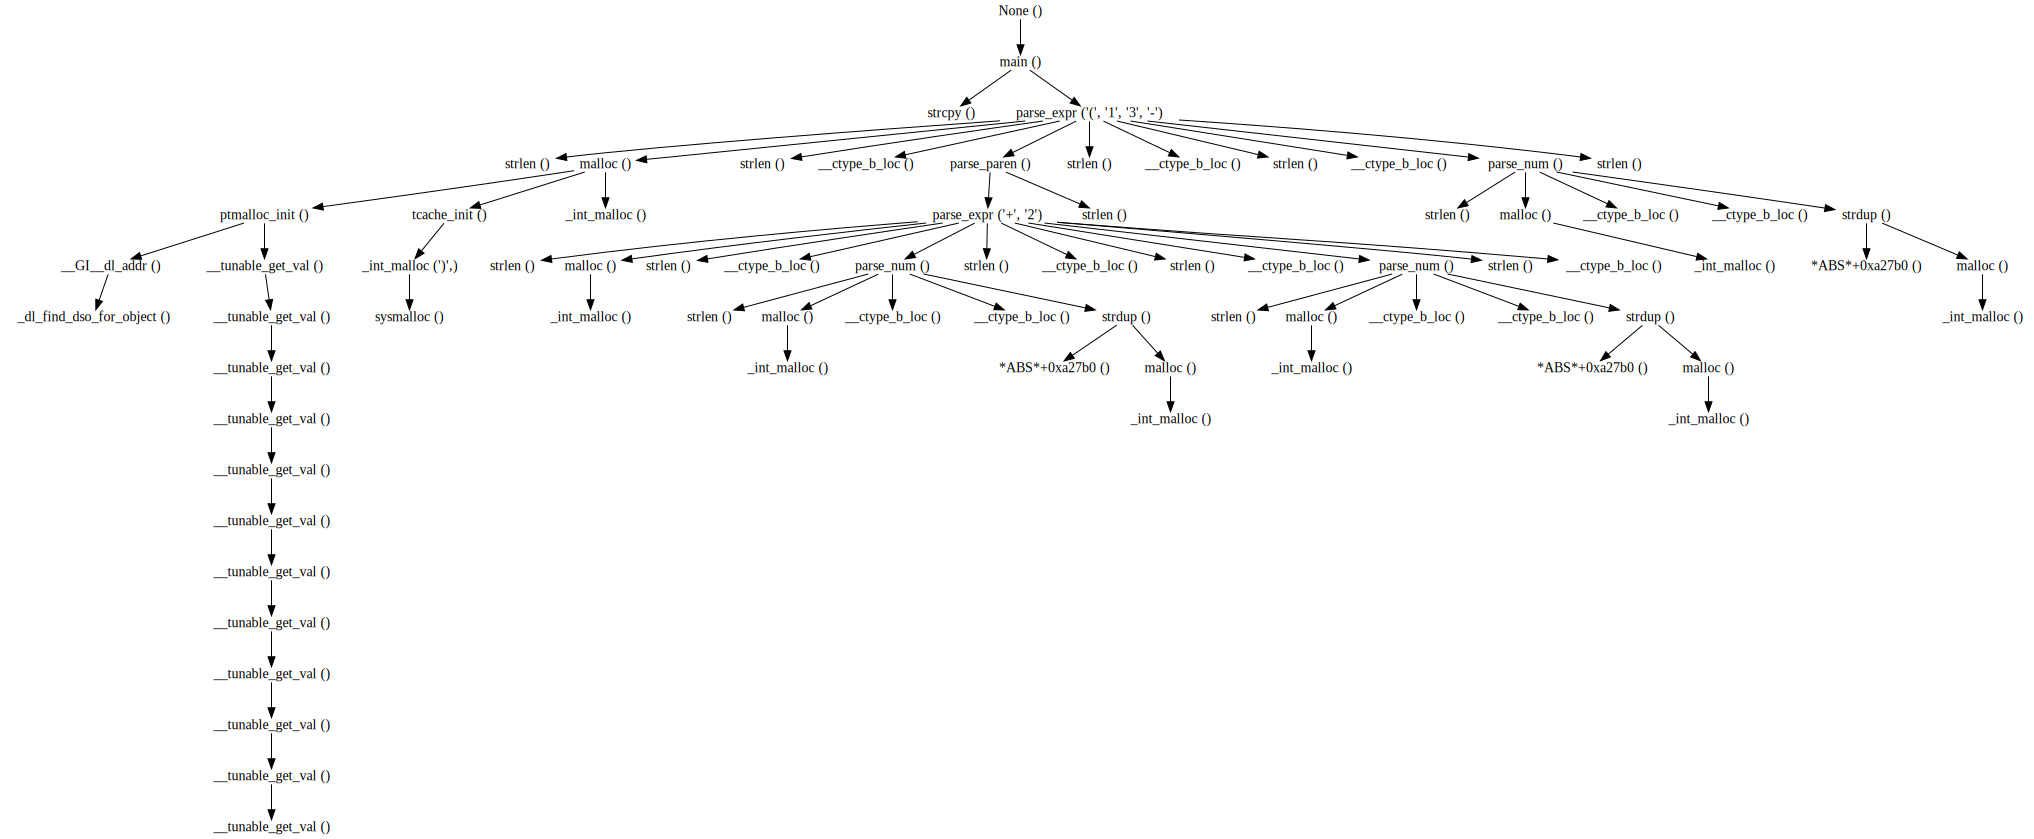

In [2488]:
display_tree(calc_method_tree[0], extract_node=extract_node1)

#### Reduce Constructed tree

Our goal here starting from the detailed tree is to iteratively reduce the tree. We carry out this tree reduction in two phases;

* Phase1: Collapse subtrees which are formed from `for, while ` loops into characters.
* Phase 2: Remove all external library functions in the tree.

In [2489]:
def isCandidate(node):
    return node['name'] and node['name'].startswith('_')

In [2490]:
def filter_tree(node):
    childrenToDelete = []
    indexesToBeAdded = []
    
    if not node['children']:
        if isCandidate(node):
            return True, node['indexes'], []
        return False, [], []
    
    for idx, child in enumerate(node['children']):
        toBeDeleted, indexesOfDeletedNode, newChildren = filter_tree(child)

        if toBeDeleted:
            childrenToDelete.append(idx)
            node['children'] += newChildren
            for di in indexesOfDeletedNode:
                indexesToBeAdded.append(di)
                
    tempIdx = []
    childrenToDelete = set(childrenToDelete)
    for i, c in enumerate(node['children']):
        if i not in childrenToDelete:
            tempIdx.append(c)
    node['children'] = list(tempIdx)
    
    for idx in indexesToBeAdded:
        node['indexes'].append(idx)
    
    if isCandidate(node):
        return True, node['indexes'], node['children']
    return False, [], []

In [2491]:
bfs(calc_method_tree[0])

(False, [], [])

#### Tree 2

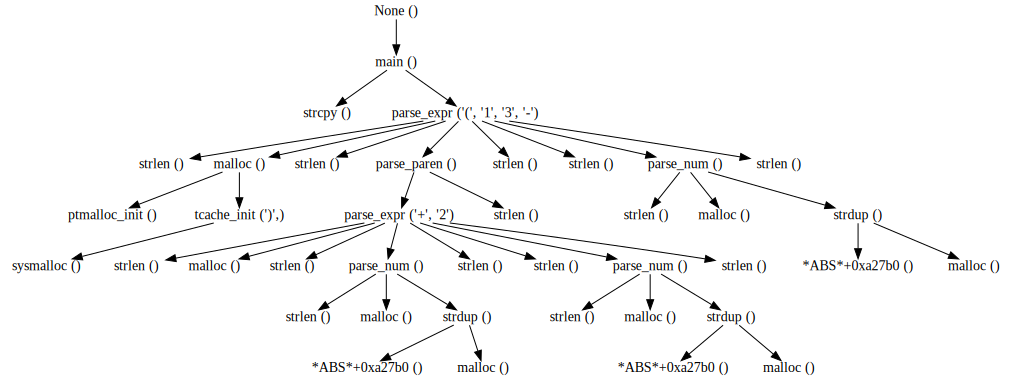

In [2492]:
display_tree(calc_method_tree[0], extract_node=extract_node1)

To remove all external library functions in the tree, we only need to redefine the function `isCandidate` to only consider nodes which are external library calls for removal.

In [2505]:
def isCandidate(node):
    return node['name'] not in ['parse_num', 'parse_expr', 'parse_paren', 'main']

#### Tree 3

In [2494]:
bfs(calc_method_tree[0])

(True,
 [],
 [{'id': 1,
   'name': 'main',
   'indexes': [],
   'children': [{'id': 3,
     'name': 'parse_expr',
     'indexes': [0, 1, 6, 5, 4],
     'children': [{'id': 27,
       'name': 'parse_paren',
       'indexes': [],
       'children': [{'id': 28,
         'name': 'parse_expr',
         'indexes': [2, 3],
         'children': [{'id': 34,
           'name': 'parse_num',
           'indexes': [],
           'children': []},
          {'id': 48, 'name': 'parse_num', 'indexes': [], 'children': []}]}]},
      {'id': 65, 'name': 'parse_num', 'indexes': [], 'children': []}]}]}])

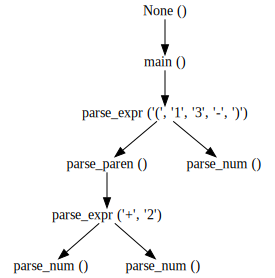

In [2495]:
display_tree(calc_method_tree[0], extract_node=extract_node1)

Convert a list of indexes to a corresponding terminal tree node

In [2496]:
def to_node(idxes, my_str):
    assert len(idxes) == idxes[-1] - idxes[0] + 1
    assert min(idxes) == idxes[0]
    assert max(idxes) == idxes[-1]
    return my_str[idxes[0]:idxes[-1] + 1], [], idxes[0], idxes[-1]

In [2497]:
from operator import itemgetter
import itertools as it

We now need to identify the terminal (leaf) nodes. For that, we want to group contiguous letters in a node together, and call it a leaf node. So, convert our list of indexes to lists of contiguous indexes first, then convert them to terminal tree nodes. Then, return a set of one level child nodes with contiguous chars from indexes.

In [2498]:
def indexes_to_children(indexes, my_str):
    lst = [
        list(map(itemgetter(1), g))
        for k, g in it.groupby(enumerate(indexes), lambda x: x[0] - x[1])
    ]

    return [to_node(n, my_str) for n in lst]

Finally, we need to remove the overlap from the trees we have so far. The idea is that, given a node, each child node of that node should be uniquely responsible for a specified range of characters, with no overlap allowed between the children. The starting of the first child to ending of the last child will be the range of the node.

#### Removing Overlap
If overlap is found, the tie is biased to the later child. That is, the later child gets to keep the range, and the former child is recursively traversed to remove overlaps from its children. If a child is completely included in the overlap, the child is excised. A few convenience functions first:

In [1567]:
def does_item_overlap(r, r_):
    (s, e), (s_, e_) = r, r_
    return ((s_ >= s and s_ <= e) or 
            (e_ >= s and e_ <= e) or 
            (s_ <= s and e_ >= e))

In [1177]:
def is_second_item_included(r, r_):
    (s, e), (s_, e_) = r, r_
    return (s_ >= s and e_ <= e)

In [1178]:
def has_overlap(ranges, r_):
    return {r for r in ranges if does_item_overlap(r, r_)}

In [1179]:
def is_included(ranges, r_):
    return {r for r in ranges if is_second_item_included(r, r_)}

In [1568]:
def remove_overlap_from(original_node, orange):
    node, children, start, end = original_node
    new_children = []
    if not children:
        return None
    start = -1
    end = -1
    for child in children:
        if does_item_overlap(child[2:4], orange):
            new_child = remove_overlap_from(child, orange)
            if new_child: # and new_child[1]:
                if start == -1: start = new_child[2]
                new_children.append(new_child)
                end = new_child[3]
        else:
            new_children.append(child)
            if start == -1: start = child[2]
            end = child[3]
    if not new_children:
        return None
    assert start != -1
    assert end != -1
    return (node, new_children, start, end)

Verify that there is no overlap.

In [1569]:
def no_overlap(arr):
    my_ranges = {}
    for a in arr:
        _, _, s, e = a
        r = (s, e)
        included = is_included(my_ranges, r)
        if included:
            continue  # we will fill up the blanks later.
        else:
            overlaps = has_overlap(my_ranges, r) 
            if overlaps:
                # unlike include which can happen only once in a set of
                # non-overlapping ranges, overlaps can happen on multiple parts.
                # The rule is, the later child gets the say. So, we recursively
                # remove any ranges that overlap with the current one from the
                # overlapped range.
                assert len(overlaps) == 1
                oitem = list(overlaps)[0]
                v = remove_overlap_from(my_ranges[oitem], r)
                del my_ranges[oitem]
                if v:
                    my_ranges[v[2:4]] = v
                my_ranges[r] = a
            else:
                my_ranges[r] = a
    res = my_ranges.values()
    # assert no overlap, and order by starting index
    s = sorted(res, key=lambda x: x[2])
    return s

#### Generate derivation tree

Convert a mapped tree to the _fuzzingbook_ style derivation tree.

In [2511]:
def to_tree(node, my_str):
    method_name = ("<%s>" % node['name']) if node['name'] is not None else '<START>'
    indexes = node['indexes']
    node_children = [to_tree(c, my_str) for c in node.get('children', [])]
    idx_children = indexes_to_children(indexes, my_str)
    children = no_overlap([c for c in node_children if c is not None] + idx_children)
    if not children:
        return None
    start_idx = children[0][2]
    end_idx = children[-1][3]
    si = start_idx
    my_children = []
    # FILL IN chars that we did not compare. This is likely due to an i + n
    # instruction.
    for c in children:
        if c[2] != si:
            sbs = my_str[si: c[2]]
            my_children.append((sbs, [], si, c[2] - 1))
        my_children.append(c)
        si = c[3] + 1

    m = (method_name, my_children, start_idx, end_idx)
    return m

In [2512]:
def is_nt(v):
    return len(v) > 1 and (v[0], v[-1]) == ('<', '>')

In [2513]:
def tree_to_str(tree): # Non recursive
    expanded = []
    to_expand = [tree]
    while to_expand:
        (key, children, *rest), *to_expand = to_expand
        if is_nt(key):
            to_expand = children + to_expand
        else:
            assert not children
            expanded.append(key)
    return ''.join(expanded)

#### Tree 3: in Fuzzing Book Style

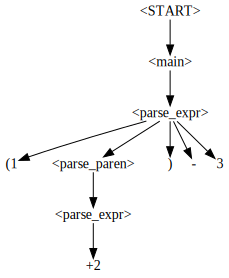

In [2514]:
display_tree(to_tree(calc_method_tree[0], calc_trace[0]['inputstr']))

In [2518]:
calc_trace[0]['inputstr']

'(1+2)-3'

In [2516]:
tree_to_str(to_tree(calc_method_tree[0], calc_trace[0]['inputstr']))

'(1+2)-3'

In [1184]:
from IPython.display import Image

In [1185]:
def zoom(v, zoom=True):
    # return v directly if you do not want to zoom out.
    if zoom:
        return Image(v.render(format='png'))
    return v

## Generating a Grammar

Generating a grammar from the generalized derivation trees is pretty simple. Start at the start node, and any node that represents a method or a pseudo method becomes a nonterminal. The children forms alternate expansions for the nonterminal. Since all the keys are compatible, merging the grammar is simply merging the hash map.

First, we define a pretty printer for grammar.

In [40]:
import re
RE_NONTERMINAL = re.compile(r'(<[^<> ]*>)')

In [41]:
def recurse_grammar(grammar, key, order, canonical):
    rules = sorted(grammar[key])
    old_len = len(order)
    for rule in rules:
        if not canonical:
            res =  re.findall(RE_NONTERMINAL, rule)
        else:
            res = rule
        for token in res:
            if token.startswith('<') and token.endswith('>'):
                if token not in order:
                    order.append(token)
    new = order[old_len:]
    for ckey in new:
        recurse_grammar(grammar, ckey, order, canonical)

In [42]:
def show_grammar(grammar, start_symbol='<START>', canonical=True):
    order = [start_symbol]
    recurse_grammar(grammar, start_symbol, order, canonical)
    if len(order) != len(grammar.keys()):
        assert len(order) < len(grammar.keys())
    return {k: sorted(grammar[k]) for k in order}

### Trees to grammar

In [43]:
def to_grammar(tree, grammar):
    node, children, _, _ = tree
    if not children: return grammar
    tokens = []
    if node not in grammar:
        grammar[node] = list()
    for c in children:
        tokens.append(c[0])
        to_grammar(c, grammar)
    grammar[node].append(tuple(tokens))
    return grammar

In [44]:
def merge_grammar(g1, g2):
    all_keys = set(list(g1.keys()) + list(g2.keys()))
    merged = {}
    for k in all_keys:
        alts = set(g1.get(k, []) + g2.get(k, []))
        merged[k] = alts
    return {k:[l for l in merged[k]] for k in merged}

In [45]:
def convert_to_grammar(my_trees):
    grammar = {}
    ret = []
    for my_tree in my_trees:
        tree = my_tree['tree']
        start = tree[0]
        src_file = my_tree['original']
        arg_file = my_tree['arg']
        ret.append((start, src_file, arg_file))
        g = to_grammar(tree, grammar)
        grammar = merge_grammar(grammar, g)
    return grammar

### Inserting Empty Alternatives for IF and Loops

Next, we want to insert empty rules for those loops and conditionals that can be skipped. For loops, the entire sequence has to contain the empty marker.

In [46]:
def check_empty_rules(grammar):
    new_grammar = {}
    for k in grammar:
        if k in ':if_':
            name, marker = k.split('#')
            if name.endswith(' *'):
                new_grammar[k] = grammar[k].add(('',))
            else:
                new_grammar[k] = grammar[k]
        elif k in ':while_':
            # TODO -- we have to check the rules for sequences of whiles.
            # for now, ignore.
            new_grammar[k] = grammar[k]
        else:
            new_grammar[k] = grammar[k]
    return new_grammar

### Learning Regular Expressions

We now need to generalize the loops. The idea is to look for patterns exclusively in the similarly named while loops using any of the regular expression learners. For the prototype, we replaced the modified Sequitur with the modified Fernau which gave us better regular expressions than before. The main constraint we have is that we want to avoid repeated execution of program if possible. Fernau algorithm can recover a reasonably approximate regular exression based only on positive data.

#### The modified Fernau algorithm

The Fernau algorithm is from _Algorithms for learning regular expressions from positive data_ by _HenningFernau_. Our algorithm uses a modified form of the Prefix-Tree-Acceptor from Fernau. First we define an LRF buffer of a given size.

In [47]:
class Buf:
    def __init__(self, size):
        self.size = size
        self.items = [None] * self.size

The `add1()` takes in an array, and transfers the first element of the array into the end of current buffer, and simultaneously drops the first element of the buffer.

In [48]:
class Buf(Buf):
    def add1(self, items):
        self.items.append(items.pop(0))
        return self.items.pop(0)

For equality between the buffer and an array, we only compare when both the array and the items are actually elements and not chunked arrays.

In [49]:
class Buf(Buf):
    def __eq__(self, items):
        if any(isinstance(i, dict) for i in self.items): return False
        if any(isinstance(i, dict) for i in items): return False
        return items == self.items

The `detect_chunks()` detects any repeating portions of a list of `n` size.

In [50]:
def detect_chunks(n, lst_):
    lst = list(lst_)
    chunks = set()
    last = Buf(n)
    # check if the next_n elements are repeated.
    for _ in range(len(lst) - n):
        lnext_n = lst[0:n]
        if last == lnext_n:
            # found a repetition.
            chunks.add(tuple(last.items))
        else:
            pass
        last.add1(lst)
    return chunks

Once we have detected plausible repeating sequences, we gather all similar sequences into arrays.

In [51]:
def chunkify(lst_,n , chunks):
    lst = list(lst_)
    chunked_lst = []
    while len(lst) >= n:
        lnext_n = lst[0:n]
        if (not any(isinstance(i, dict) for i in lnext_n)) and tuple(lnext_n) in chunks:
            chunked_lst.append({'_':lnext_n})
            lst = lst[n:]
        else:
            chunked_lst.append(lst.pop(0))
    chunked_lst.extend(lst)
    return chunked_lst

The `identify_chunks()` simply calls the `detect_chunks()` on all given lists, and then converts all chunks identified into arrays.

In [52]:
def identify_chunks(my_lsts):
    # initialize
    all_chunks = {}
    maximum = max(len(lst) for lst in my_lsts)
    for i in range(1, maximum//2+1):
        all_chunks[i] = set()

    # First, identify chunks in each list.
    for lst in my_lsts:
        for i in range(1,maximum//2+1):
            chunks = detect_chunks(i, lst)
            all_chunks[i] |= chunks

    # Then, chunkify
    new_lsts = []
    for lst in my_lsts:
        for i in range(1,maximum//2+1):
            chunks = all_chunks[i]
            lst = chunkify(lst, i, chunks)
        new_lsts.append(lst)
    return new_lsts

##### Prefix tree acceptor

The prefix tree acceptor is a way to represent positive data. The `Node` class holds a single node in the prefix tree acceptor.

In [53]:
class Node:
    # Each tree node gets its unique id.
    _uid = 0
    def __init__(self, item):
        # self.repeats = False
        self.count = 1 # how many repetitions.
        self.counters = set()
        self.last = False
        self.children = []
        self.item = item
        self.uid = Node._uid
        Node._uid += 1

    def update_counters(self):
        self.counters.add(self.count)
        self.count = 0
        for c in self.children:
            c.update_counters()

    def __repr__(self):
        return str(self.to_json())

    def __str__(self):
        return str("(%s, [%s])", (self.item, ' '.join([str(i) for i in self.children])))

    def to_json(self):
        s = ("(%s)" % ' '.join(self.item['_'])) if isinstance(self.item, dict) else str(self.item)
        return (s, tuple(self.counters), [i.to_json() for i in self.children])

    def inc_count(self):
        self.count += 1

    def add_ref(self):
        self.count = 1

    def get_child(self, c):
        for i in self.children:
            if i.item == c: return i
        return None

    def add_child(self, c):
        # first check if it is the current node. If it is, increment
        # count, and return ourselves.
        if c == self.item:
            self.inc_count()
            return self
        else:
            # check if it is one of the children. If it is a child, then
            # preserve its original count.
            nc = self.get_child(c)
            if nc is None:
                nc = Node(c)
                self.children.append(nc)
            else:
                nc.add_ref()
            return nc

The `update_tree()` essentially transforms a list of nodes to a chain of nodes starting at `root` if the `root` is an empty tree. If the `root` already contains a tree, the `update_tree()` traverses the path represented by `lst_` and makes a new child branch where the path specified doesn't exist in the tree.

In [54]:
def update_tree(lst_, root):
    lst = list(lst_)
    branch = root
    while lst:
        first, *lst = lst
        branch = branch.add_child(first)
    branch.last = True
    return root

Given a number of lists, the `create_tree_with_lists()` creates an actual tree out of these lists.

In [55]:
def create_tree_with_lsts(lsts):
    Node._uid = 0
    root =  Node(None)
    for lst in lsts:
        root.count = 1 # there is at least one element.
        update_tree(lst, root)
        root.update_counters()
    return root

Given a node, and a key, return the key and alts as a dict.

In [56]:
def get_star(node, key):
    if node.item is None:
        return [], {}
    if isinstance(node.item, dict):
        # take care of counters
        elements = node.item['_']
        my_key = "<%s-%d-s>" % (key, node.uid)
        alts = [elements]
        if len(node.counters) > 1: # repetition
            alts.append(elements + [my_key])
        return [my_key], {my_key:alts}
    else:
        return [str(node.item)], {}

In [57]:
def node_to_grammar(node, grammar, key):
    rule = []
    alts = [rule]
    if node.uid == 0:
        my_key = "<%s>" % key
    else:
        my_key = "<%s-%d>" % (key, node.uid)
    grammar[my_key] = alts
    if node.item is not None:
        mk, g = get_star(node, key)
        rule.extend(mk)
        grammar.update(g)
    # is the node last?
    if node.last:
        assert node.item is not None
        # add a duplicate rule that ends here.
        ending_rule = list(rule)
        # if there are no children, the current rule is
        # any way ending.
        if node.children:
            alts.append(ending_rule)

    if node.children:
        if len(node.children) > 1:
            my_ckey = "<%s-%d-c>" % (key, node.uid)
            rule.append(my_ckey)
            grammar[my_ckey] = [ ["<%s-%d>" % (key, c.uid)] for c in node.children]
        else:
            my_ckey = "<%s-%d>" % (key, node.children[0].uid)
            rule.append(my_ckey)
    else:
        pass
    for c in node.children:
        node_to_grammar(c, grammar, key)
    return grammar

def generate_grammar(lists, key):
    lsts = identify_chunks(lists)
    tree = create_tree_with_lsts(lsts)
    grammar = {}
    node_to_grammar(tree, grammar, key)
    return grammar

Given a rule, determine the abstraction for it.

In [58]:
def collapse_alts(rules, k):
    ss = [[str(r) for r in rule] for rule in rules]
    x = generate_grammar(ss, k[1:-1])
    return x

In [59]:
def collapse_rules(grammar):
    r_grammar = {}
    for k in grammar:
        new_grammar = collapse_alts(grammar[k], k)
        # merge the new_grammar with r_grammar
        # we know none of the keys exist in r_grammar because
        # new keys are k prefixed.
        for k_ in new_grammar:
            r_grammar[k_] = new_grammar[k_]
    return r_grammar

In [60]:
def convert_spaces_in_keys(grammar):
    keys = {key: key.replace(' ', '_') for key in grammar}
    new_grammar = {}
    for key in grammar:
        new_alt = []
        for rule in grammar[key]:
            new_rule = []
            for t in rule:
                for k in keys:
                    t = t.replace(k, keys[k])
                new_rule.append(t)
            new_alt.append(new_rule)
        new_grammar[keys[key]] = new_alt
    return new_grammar

### Remove duplicate and redundant entries

**IMPORTANT** we indicate things that operate on canonical by _c, and those that operate on fuzzable by _f, and both by _cf

In [61]:
def first_in_chain(token, chain):
    while True:
        if token in chain:
            token = chain[token]
            assert isinstance(token, str)
        else:
            break
    return token

Return a new symbol for `grammar` based on `symbol_name`.

In [62]:
def new_symbol(grammar, symbol_name="<symbol>"):
    if symbol_name not in grammar:
        return symbol_name

    count = 1
    while True:
        tentative_symbol_name = symbol_name[:-1] + "-" + repr(count) + ">"
        if tentative_symbol_name not in grammar:
            return tentative_symbol_name
        count += 1

Replace keys that have a single token definition with the token in the defition.

In [63]:
def replacement_candidate_chains(grammar, ignores):
    to_replace = {}
    for k in grammar:
        if k in ignores: continue
        if len(grammar[k]) != 1: continue
        rule = grammar[k][0]
        if len(rule) != 1: continue
        if is_nt(rule[0]):
            to_replace[k] = rule[0]
        else:
            pass
    return to_replace

In [64]:
def replace_key_by_new_key(grammar, keys_to_replace):
    new_grammar = {}
    for key in grammar:
        new_rules = []
        for rule in grammar[key]:
            new_rule = [keys_to_replace.get(token, token)
                        for token in rule]
            new_rules.append(new_rule)
        new_grammar[keys_to_replace.get(key, key)] = new_rules
    assert len(grammar) == len(new_grammar)
    return new_grammar

In [65]:
def replace_key_by_key(grammar, keys_to_replace):
    new_grammar = {}
    for key in grammar:
        if key in keys_to_replace: continue
        new_rules = []
        for rule in grammar[key]:
            for t in rule:
                assert isinstance(t, str)
            new_rule = [first_in_chain(token, keys_to_replace) for token in rule]
            new_rules.append(new_rule)
        new_grammar[key] = new_rules
    return new_grammar

In [66]:
def remove_single_entries(grammar):
    keys_to_replace = replacement_candidate_chains(grammar, {start_symbol, '<main>'})
    return replace_key_by_key(grammar, keys_to_replace)

Remove keys that have similar rules.

In [67]:
def collect_duplicate_rule_keys(grammar):
    collect = {}
    for k in grammar:
        salt = str(sorted(grammar[k]))
        if salt not in collect:
            collect[salt] = (k, set())
        else:
            collect[salt][1].add(k)
    return collect

In [68]:
def remove_duplicate_rule_keys(grammar):
    g = grammar
    while True:
        collect = collect_duplicate_rule_keys(g)
        keys_to_replace = {}
        for salt in collect:
            k, st = collect[salt]
            for s in st:
                keys_to_replace[s] = k
        if not keys_to_replace:
            break
        g = replace_key_by_key(g, keys_to_replace)
    return g

Remove all the control flow vestiges from names, and simply name them sequentially.

In [69]:
def deep_copy(t): # Python deepcopy is a bit buggy
    v = json.dumps(t)
    return json.loads(v)

In [70]:
def collect_replacement_keys(grammar):
    g = deep_copy(grammar)
    to_replace = {}
    for k in grammar:
        if ':' in k:
            first, rest = k.split(':')
            sym = new_symbol(g, symbol_name=first + '>')
            assert sym not in g
            g[sym] = None
            to_replace[k] = sym
        else:
            continue
    return to_replace

Remove keys that are referred to only from a single rule, and which have a single alternative.
Import. This can't work on canonical representation. First, given a key, we figure out its distance to `<START>`.

This is different from `remove_single_entries()` in that, there we do not care if the key is being used multiple times. Here, we only replace keys that are referred to only once.

In [71]:
import math

In [72]:
def len_to_start(item, parents, start_symbol, seen=None):
    if seen is None: seen = set()
    if item in seen: return math.inf
    seen.add(item)
    if item == start_symbol: return 0
    else: return 1 + min(len_to_start(p, parents, start_symbol, seen)
                         for p in parents[item])

In [73]:
def order_by_length_to_start(items, parent_map, start_symbol):
    return sorted(items, key=lambda i: len_to_start(i, parent_map, start_symbol))

Next, we generate a map of `child -> [parents]`.

In [74]:
def get_parents_of_tokens(grammar, key, seen=None, parents=None):
    if parents is None: parents, seen = {}, set()
    if key in seen: return parents
    seen.add(key)
    for res in grammar[key]:
        for token in res:
            if not is_nt(token): continue
            parents.setdefault(token, []).append(key)
    for ckey in {i for i in  grammar if i not in seen}:
        get_parents_of_tokens(grammar, ckey, seen, parents)
    return parents

In [75]:
def remove_references(keys_to_replace):
    to_process = list(keys_to_replace.keys())
    updated_dict = {}
    references = {}
    order = []
    while to_process:
        key, *to_process = to_process
        rule = keys_to_replace[key]
        new_rule = []
        skip = False
        for token in rule:
            if token not in updated_dict:
                if token in to_process:
                    # so this token will get defined later. We simply postpone
                    # the processing of this key until that key is defined.
                    # TODO: check for cycles.
                    to_process.append(key)
                    references.setdefault(token, set()).add(key)
                    skip = True
                    break
                else:
                    new_rule.append(token)
            else:
                new_rule.extend(updated_dict[token])
        if not skip:
            order.append(key)
            updated_dict[key] = new_rule
    return updated_dict

In [76]:
def replace_keys_by_rule(grammar, keys_to_replace):
    # we now need to verify that none of the keys are part of the sequences.
    keys_to_replace = remove_references(keys_to_replace)

    new_grammar = {}
    for key in grammar:
        if key in keys_to_replace: continue

        new_rules = []
        for rule in grammar[key]:
            new_rule = []
            for token in rule:
                if token in keys_to_replace:
                    new_rule.extend(keys_to_replace[token])
                else:
                    new_rule.append(token)
            new_rules.append(new_rule)
        new_grammar[key] = new_rules
    return new_grammar

Now, all together.

In [77]:
def remove_single_alts(grammar, start_symbol):
    single_alts = {p for p in grammar if len(grammar[p]) == 1 and p != start_symbol}

    child_parent_map = get_parents_of_tokens(grammar, start_symbol)
    assert len(child_parent_map) < len(grammar)

    single_refs = {p:child_parent_map[p] for p in single_alts if len(child_parent_map[p]) <= 1}

    ordered = order_by_length_to_start(single_refs, child_parent_map, start_symbol)

    for p in ordered:
        assert len(grammar[p]) == 1
        if not isinstance(grammar[p][0], str):
            print(p, grammar[p][0])

    keys_to_replace = {p:grammar[p][0] for p in ordered}
    g =  replace_keys_by_rule(grammar, keys_to_replace)
    return g

remove similar rules from under a single key

In [78]:
def len_rule(r): return len(r)
def len_definition(d): return sum([len_rule(r) for r in d])
def len_grammar(g): return sum([len_definition(g[k]) for k in g])

In [79]:
def remove_duplicate_rules_in_a_key(g):
    g_ = {}
    for k in g:
        s = {str(r):r for r in g[k]}
        g_[k] = list(sorted(list(s.values())))
    return g_

In [80]:
def grammar_gc(grammar, start_symbol):
    def strip_key(grammar, key, order):
        rules = sorted(grammar[key])
        old_len = len(order)
        for rule in rules:
            for token in rule:
                if is_nt(token):
                    if token not in order:
                        order.append(token)
        new = order[old_len:]
        for ckey in new:
            strip_key(grammar, ckey, order)

    order = [start_symbol]
    strip_key(grammar, start_symbol, order)
    assert len(order) == len(grammar.keys())
    g = {k: sorted(grammar[k]) for k in order}
    for k in g:
        for r in g[k]:
            for t in r:
                assert isinstance(t, str)
    return g

In [81]:
def cleanup_grammar(g, start_symbol):
    g = grammar_gc(g, start_symbol)
    g1 = check_empty_rules(g) # add optional rules
    g1 = grammar_gc(g1, start_symbol)
 
    g2 = collapse_rules(g1) # learn regex
    g2 = grammar_gc(g2, start_symbol)

    g3 = convert_spaces_in_keys(g2) # fuzzable grammar
    g3 = grammar_gc(g3, start_symbol)
    return g3

In [82]:
def remove_single_entry_chains(grammar, start_symbol):
    keys_to_replace = replacement_candidate_chains(grammar, {start_symbol, '<main>'})
    return replace_key_by_key(grammar, keys_to_replace)

In [83]:
def cleanup_token_names(grammar):
    keys_to_replace = collect_replacement_keys(grammar)
    g = replace_key_by_new_key(grammar, keys_to_replace)
    return g

In [84]:
def remove_self_definitions(g):
    g_ = {}
    for k in g:
        rs_ = []
        for r in g[k]:
            assert not isinstance(r, str)
            if len(r) == 1 and r[0] == k: continue
            rs_.append(r)
        g_[k] = rs_
    return g_

In [85]:
def compact_grammar(e, start_symbol):
    assert start_symbol in e
    l = len_grammar(e)
    diff = 1
    while diff > 0:
        assert start_symbol in e
        e = remove_single_entry_chains(e, start_symbol)
        e = grammar_gc(e, start_symbol) # garbage collect

        e = remove_duplicate_rule_keys(e)
        e = grammar_gc(e, start_symbol) # garbage collect

        e = cleanup_token_names(e)
        e = grammar_gc(e, start_symbol) # garbage collect

        e = remove_single_alts(e, start_symbol)
        e = grammar_gc(e, start_symbol) # garbage collect

        e = remove_duplicate_rules_in_a_key(e)
        e = grammar_gc(e, start_symbol) # garbage collect

        e = remove_self_definitions(e)
        e = grammar_gc(e, start_symbol) # garbage collect

        l_ = len_grammar(e)
        diff = l - l_
        l = l_
    e = grammar_gc(e, start_symbol)
    return e

### The Complete Miner

We now put everything together. The `miner()` takes the traces, produces trees out of them, and verifies that the trees actually correspond to the input.

In [88]:
def miner(call_traces):
    my_trees = []
    for call_trace in call_traces:
        method_map = call_trace['method_map']

        first, method_tree = reconstruct_method_tree(method_map)
        comparisons = call_trace['comparisons']
        attach_comparisons(method_tree, last_comparisons(comparisons))

        my_str = call_trace['inputstr']

        tree = to_tree(method_tree[first], my_str)
        my_tree = {'tree': tree, 'original': call_trace['original'], 'arg': call_trace['arg']}
        print(tree_to_str(tree))
        assert tree_to_str(tree) == my_str
        my_trees.append(my_tree)
    return my_trees

In [107]:
import jsonpickle
from fuzzingbook.Parser import non_canonical, canonical

In [109]:
def binary_miner(seeds, executable, flag=None):
    call_trace = []
    for inp in seeds:
        arg0 = '\'py arg0="%s"\'' % inp
        arg1 = '\'py arg1="%s"\'' % executable
        
        with open(f'inp.0.txt', 'w+') as f:
            print(inp, file=f)
        
        if flag:
            !gcc -g {executable} {flag}
        else: 
            !gcc -g {executable}
            
        !gdb --batch-silent -ex {arg1} -x bminer.py
        with open(f'tree', 'rb') as f:
            call_trace.append((jsonpickle.decode(f.read())))
            
    mined_tree = miner(call_trace)
    g0 = convert_to_grammar(mined_tree)
    g = cleanup_grammar(g0, start_symbol='<START>')
    g = compact_grammar(g, start_symbol='<START>')
    return show_grammar(non_canonical(g), canonical=False)

# Evaluation

In [194]:
Max_Precision = 1000
Max_Recall = 1000
BMiner = {}
BMinerFuzz = {}
BMinerGrammar = {}
MaxTimeout = 60*60*24 # 2 day
MaxParseTimeout = 60*5
CHECK = {'calculator', 'parson', 'tinyc', 'csv', 'mjs', 'lisp', 'yxml', 'duktape'}

### Check Recall

How many of the *valid* inputs from the golden grammar can be recognized by a parser using our grammar?

In [91]:
from fuzzingbook.Parser import IterativeEarleyParser

In [92]:
def check_recall(golden_grammar, my_grammar, maximum=Max_Recall, start_symbol='<START>', log=False):
    my_count = maximum
    ie = IterativeEarleyParser(my_grammar, start_symbol=start_symbol)
    golden = GrammarFuzzer(golden_grammar, start_symbol=start_symbol)
    success = 0
    while my_count != 0:
        src = golden.fuzz()
        try:
            my_count -= 1
            try:
                # print('?', repr(src), file=sys.stderr)
                for tree in ie.parse(src):
                    success += 1
                    break
                if log: print(maximum - my_count, '+', repr(src), success, file=sys.stderr)
            except:
                #print("Error:", sys.exc_info()[0], file=sys.stderr)
                if log: print(maximum - my_count, '-', repr(src), file=sys.stderr)
                pass
        except:
            pass
    return (success, maximum)

### Check Precision
How many of the inputs produced using our grammar are valid? (Accepted by the program).

In [93]:
def check_precision(name, grammar, maximum=Max_Precision, start_symbol='<START>', log=False):
    success = 0
    with ExpectError():
        fuzzer = GrammarFuzzer(grammar, start_symbol)
        for i in range(maximum):
            v = fuzzer.fuzz(key=start_symbol)
            c = check_it(v, name)
            success += (1 if c else 0)
            if log: print(i, repr(v), c)
    return (success, maximum)

In [94]:
class timeit():
    def __enter__(self):
        self.tic = datetime.now()
        return self
    def __exit__(self, *args, **kwargs):
        self.delta = datetime.now() - self.tic
        self.runtime = (self.delta.microseconds, self.delta)

### Timer

In [95]:
from datetime import datetime
from fuzzingbook.GrammarFuzzer import GrammarFuzzer

## Subjects

In [96]:
BMiner_p = {}
BMiner_r = {}

BMiner_t ={}

### Calculator

####  Golden Grammar

In [97]:
calc_golden = {
  "<START>": [
    "<expr>"
  ],
  "<expr>": [
    "<term>+<expr>",
    "<term>-<expr>",
    "<term>"
  ],
  "<term>": [
    "<factor>*<term>",
    "<factor>/<term>",
    "<factor>"
  ],
  "<factor>": [
    "(<expr>)",
    "<number>"
  ],
  "<number>": [
    "<integer>.<integer>",
    "<integer>"
  ],
  "<integer>": [
    "<digit><integer>",
    "<digit>"
  ],
  "<digit>": [ "0", "1", "2", "3", "4", "5", "6", "7", "8", "9" ]
}

#### Samples

In [251]:
calc_samples=[i.strip() for i in '''\
(1+2)*3/(423-334+9983)-5-((6)-(701))
(123+133*(12-3)/9+8)+33
(100)
21*3
33/44+2
100
23*234*22*4
1+2
31/20-2
555+(234-445)
1-(41/2)
443-334+33-222
'''.split('\n') if i.strip()]

In [368]:
calc_grammar = binary_miner([calc_samples[1]], 'subject/calc/calc_parse.c')
calc_grammar

(123+133*(12-3)/9+8)+33
<main> ['<parse_expr-0-c>']
<parse_expr-5> ['<__ctype_b_loc-0-c>', '<parse_expr-6>']
<parse_expr-2> ['<parse_expr-2-s>', '<parse_expr-3>']
<parse_expr-6> ['<strlen-0-c>', '<parse_expr-7>']
<__GI__dl_addr-1> ['<_dl_find_dso_for_object-1>', '<__tunable_get_val-0-c>']
<parse_expr-3> ['<parse_expr-3-s>', '<parse_expr-4-s>']
<parse_expr-7> ['<parse_expr-0-c>', '<parse_expr-8>']
<_int_malloc-1> ['1']
<parse_expr-8> ['<strlen-0-c>', '<parse_expr-9>']
<parse_expr-9> ['<__ctype_b_loc-0-c>', '<__tunable_get_val-3>']
<__tunable_get_val-2> ['<parse_expr-0-c>', '<__tunable_get_val-3>']
<__ctype_b_loc-7> ['123+']
<__ctype_b_loc-3> ['-']
<__ctype_b_loc-1> [')']
<__ctype_b_loc-8> ['2']
<__ctype_b_loc-4> ['1', '<__ctype_b_loc-5>']
<strlen-6> ['9']
<strlen-3> ['/']
<strlen-5> ['8']
<__ctype_b_loc-5> ['33', '<__ctype_b_loc-6>']
<__ctype_b_loc-6> ['*']
<__tunable_get_val-0-c> ['<parse_expr-0-c>', '<__tunable_get_val-3>']


{'<START>': ['<parse_expr-0-c>'],
 '<parse_expr-0-c>': ['<__ctype_b_loc-0-c><strlen-0-c><parse_expr-0-c><strlen-0-c><__ctype_b_loc-0-c><__tunable_get_val-3>',
  '<parse_expr-1>'],
 '<__ctype_b_loc-0-c>': [')',
  '-',
  '123+',
  '133*',
  '2',
  '<strlen-2>',
  '<strlen-4>'],
 '<strlen-0-c>': ['/',
  '8',
  '9',
  '<_dl_find_dso_for_object-1>',
  '<strlen-2>',
  '<strlen-4>'],
 '<__tunable_get_val-3>': ['<strlen-0-c><__ctype_b_loc-0-c>'],
 '<parse_expr-1>': ['<malloc-0-c>',
  '<malloc-0-c><parse_expr-2-s><parse_expr-3-s><parse_expr-4-s>'],
 '<strlen-2>': ['+'],
 '<strlen-4>': ['3'],
 '<_dl_find_dso_for_object-1>': ['('],
 '<malloc-0-c>': ['1',
  '<_dl_find_dso_for_object-1><parse_expr-0-c><__tunable_get_val-3>'],
 '<parse_expr-2-s>': ['<__ctype_b_loc-0-c>',
  '<__ctype_b_loc-0-c><parse_expr-2-s>'],
 '<parse_expr-3-s>': ['<strlen-0-c>', '<strlen-0-c><parse_expr-3-s>'],
 '<parse_expr-4-s>': ['<__ctype_b_loc-0-c>',
  '<__ctype_b_loc-0-c><parse_expr-4-s>']}

In [253]:
if 'calculator' in CHECK:
    result = check_recall(calc_golden, calc_grammar, start_symbol='<START>')
    BMiner_r['calculator.py'] = result
    print(result)

(396, 1000)


### cJSON

Parson is a lightweight json library written in C.

#### Samples

In [1532]:
#json_samples = [i.strip() for i in '''\
#{"emptya":[],"emptyh":{},"emptystr":"","null":"null"}
#{"color":"blue","category":"hue","type":"primary","code":{"rgba":[0,0,255,1],"hex":"#00F"}}
#{"color":"yellow","category":"hue","wetype":"primary","code":{"rgba":[255,255,0,1],"hex":"#FF0"}}
#{"color":"green","category":"hue","type":"secondary","code":{"rgba":[0,255,0,1],"hex":"#0F0"}
#'''.split('\n') if i.strip()]

In [1534]:
#parson_grammar = binary_miner([json_samples[0]], 'subject/json/cJSON.c')
#parson_grammar

### MJS

#### Golden Grammar

In [219]:
import string
mjs_golden = {
    '<START>': ['<program>'],
    '<program>': ['<statement>'],
    '<statement>': ['if <paren_expr> <statement>', 'if <paren_expr> <statement> else <statement>',
                   'while <paren_expr> <statement>', 'do <statement> while <paren_expr>;',
                   '{ <statement> }', '<expr> ;', ';'],
    '<paren_expr>': ['(<expr>)'],
    '<expr>': ['<test>', '<id>=<expr>'],
    '<test>': ['<sum>', '<sum><<sum>'],
    '<sum>': ['<term>', '<sum>+<term>', '<sum>-<term>'],
    '<term>': ['<id>', '<int>', '<paren_expr>'],
    '<id>': list(string.ascii_lowercase),
    '<int>': list(string.digits)
}

#### Samples

In [321]:
mjs_samples=[i.strip() for i in '''\
{ i=7; if (i<5) x=1; if (i<10) y=2; }
{ i=1; while (i<100) i=i+i; }
a=b=c=2<3;
{ i=1; while ((i=i+10)<50) ; }
'''.split('\n') if i.strip()]

In [367]:
mjs_grammar = binary_miner([mjs_samples[0]], 'subject/mjs/mjs.c')
mjs_grammar

{ i=7; if (i<5) x=1; if (i<10) y=2; }
<main> ['<parse_statement_list-1>']
<parse_if-1> ['<pnext-1>', '<parse_if-2>']
<parse_if-2> ['<parse_assignment-0-c>', '<parse_if-3>']
<parse_if-3> ['<pnext-1>', '<parse_statement-0-c>']
<skip_spaces_and_comments-4> ['7']
<skip_spaces_and_comments-1> ['1']
<skip_spaces_and_comments-3> ['5']
<skip_spaces_and_comments-2> ['2']
<skip_spaces_and_comments-7> ['{']
<*ABS*+0xa27b0-3> [';']
<mjs_is_space-4> ['x']
<mjs_is_space-2> ['(']
<*ABS*+0xa27b0-1> [')']
<*ABS*+0xa27b0-2> ['0)']
<mjs_is_space-6> ['}']
<mjs_is_space-5> ['y']
<mjs_is_alpha-1> ['<']
<mjs_is_alpha-2> ['=']
<mjs_is_alpha-3> ['f']


{'<START>': ['<parse_statement_list-1>'],
 '<parse_statement_list-1>': ['<parse_statement_list-1-s>',
  '<parse_statement_list-1-s><pnext-1>'],
 '<parse_statement_list-1-s>': ['<pnext-1><parse_statement-0-c>',
  '<pnext-1><parse_statement-0-c><parse_statement_list-1-s>'],
 '<pnext-1>': ['<skip_spaces_and_comments-0-c>',
  '<skip_spaces_and_comments-0-c><pnext-1-c>'],
 '<parse_statement-0-c>': ['<parse_statement_list-1>',
  '<pnext-1>',
  '<pnext-1><pnext-1><pnext-1><parse_statement-0-c>'],
 '<skip_spaces_and_comments-0-c>': ['1',
  '2',
  '5',
  '7',
  '<mjs_is_space-0-c>',
  '<skip_spaces_and_comments-6>',
  '{'],
 '<pnext-1-c>': ['<*ABS*+0xa27b0-0-c>', '<mjs_is_ident-0-c>'],
 '<mjs_is_space-0-c>': ['(',
  '<mjs_is_space-1>',
  '<skip_spaces_and_comments-6>',
  'x',
  'y',
  '}'],
 '<skip_spaces_and_comments-6>': ['i'],
 '<mjs_is_space-1>': [' '],
 '<*ABS*+0xa27b0-0-c>': [')', '0)', ';'],
 '<mjs_is_ident-0-c>': ['<mjs_is_alpha-0-c>', '<mjs_is_space-1>'],
 '<mjs_is_alpha-0-c>': ['<', '

In [222]:
if 'mjs' in CHECK:
    result = check_recall(mjs_golden, mjs_grammar, start_symbol='<START>')
    BMiner_r['mjs.c'] = result
    print(result)

(34, 1000)


### Duktape
Duktape is an embeddable Javascript engine, with a focus on portability and compact footprint.

#### Golden Grammar

In [140]:
import string
duktape_golden = {
    '<START>': ['<program>'],
    '<program>': ['<statement>'],
    '<statement>': ['if <paren_expr> <statement>', 'if <paren_expr> <statement> else <statement>',
                   'while <paren_expr> <statement>', 'do <statement> while <paren_expr>;',
                   '{ <statement> }', '<expr> ;', ';'],
    '<paren_expr>': ['(<expr>)'],
    '<expr>': ['<test>', '<id>=<expr>'],
    '<test>': ['<sum>', '<sum><<sum>'],
    '<sum>': ['<term>', '<sum>+<term>', '<sum>-<term>'],
    '<term>': ['<id>', '<int>', '<paren_expr>'],
    '<id>': list(string.ascii_lowercase),
    '<int>': list(string.digits)
}

#### Samples

In [141]:
duktape_samples=[i.strip() for i in '''\
{ i=1; while (i<100) i=i+i; }
'''.split('\n') if i.strip()]

In [104]:
import sys
#print(sys.getrecursionlimit())
sys.setrecursionlimit(40000)

In [110]:
duktape_grammar = binary_miner(duktape_samples, 'subject/duktape/duktape.c', '-lm')
duktape_grammar

{ i=1; while (i<100) i=i+i; }
<main> ['<duk_default_alloc_function-0-c>']
<duk__heap_suppress_debuglog-1> [' ']
<duk_heap_hashstring-6> ['}']
<duk_heap_hashstring-2> ['1']
<duk_heap_hashstring-5> ['w']
<duk__strtable_alloc_hstring-9> ['<duk_heap_mem_alloc-0-c>', '<duk__strtable_alloc_hstring-9-c>']
<duk__strtable_alloc_hstring-1> [')', '<duk__strtable_alloc_hstring-2>']
<duk__strtable_alloc_hstring-4> ['+', '<duk__strtable_alloc_hstring-2>']
<duk_bd_decode-9> ['l']
<duk_bd_decode-1> ['(']
<duk_bd_decode-7> ['h']
<duk_bd_decode-3> [';']
<duk_bd_decode-6> ['e']
<duk_bd_decode-4> ['<']
<duk_bd_decode-10> ['{']


{'<START>': ['<duk_default_alloc_function-0-c>'],
 '<duk_default_alloc_function-0-c>': [' ', '<memset-0-c>'],
 '<memset-0-c>': ['<duk_default_alloc_function-0-c>',
  '<duk_heap_strtable_intern-0-c>',
  '<duk_js_to_arrayindex_string-1>'],
 '<duk_heap_strtable_intern-0-c>': ['<duk__strtable_do_intern-0-c>',
  '<duk_heap_strtable_intern-2>'],
 '<duk_js_to_arrayindex_string-1>': ['i'],
 '<duk__strtable_do_intern-0-c>': ['<duk__strtable_alloc_hstring-0-c>',
  '<duk_heap_mem_alloc-0-c>'],
 '<duk_heap_strtable_intern-2>': ['<duk_heap_hashstring-0-c>',
  '<duk_heap_hashstring-0-c><duk__strtable_do_intern-0-c>'],
 '<duk__strtable_alloc_hstring-0-c>': [')<duk__strtable_alloc_hstring-2>',
  '+<duk__strtable_alloc_hstring-2>',
  '<duk__strtable_alloc_hstring-7>',
  '<duk_heap_mem_alloc-0-c><duk__strtable_alloc_hstring-9-c>',
  '<duk_heap_strtable_intern-0-c>'],
 '<duk_heap_mem_alloc-0-c>': ['<duk_default_alloc_function-0-c>',
  '<memset-0-c>'],
 '<duk__strtable_alloc_hstring-2>': ['<duk_heap_mem_a

In [144]:
if 'duktape' in CHECK:
    result = check_recall(duktape_golden, duktape_grammar, start_symbol='<START>')
    BMiner_r['duktape.c'] = result
    print(result)

(20, 1000)


### CSV 

#### The Golden Grammar

In [210]:
import string

CSV_GRAMMAR = {
    '<START>': ['<csvline>'],
    '<csvline>': ['<items>'],
    '<items>': ['<item>,<items>', '<item>'],
    '<item>': ['<letters>'],
    '<letters>': ['<letter><letters>', '<letter>'],
    '<letter>': list(string.ascii_letters + string.digits + string.punctuation + ' \t\n')
}

#### Samples

In [358]:
from fuzzingbook.GrammarMiner import VEHICLES

In [359]:
csv_grammar = binary_miner(VEHICLES, 'subject/csv/csv.c')
csv_grammar

1997,van,Ford,E350
2000,car,Mercury,Cougar
1999,car,Chevy,Venture
<main> ['<__tunable_get_val-0-c>']
<csv_load-2> ['<getc-1>', '<csv_load-3-s>']
<_int_realloc-9> ['Venture']
<_int_realloc-3> ['2000']
<_int_realloc-1> ['1997']
<_int_realloc-10> ['car']
<_int_realloc-11> ['van']
<_int_realloc-8> ['Mercury']
<_int_realloc-4> ['Chevy']
<_int_realloc-7> ['Ford']
<_int_realloc-2> ['1999']
<_int_realloc-5> ['Cougar']
<_int_realloc-6> ['E350']


{'<START>': ['<csv_load-1>'],
 '<csv_load-1>': ['<csv_load-1-s>', '<csv_load-1-s><getc-1><csv_load-3-s>'],
 '<csv_load-1-s>': ['<read_next_field-1>',
  '<read_next_field-1><csv_load-1-s>'],
 '<getc-1>': [','],
 '<csv_load-3-s>': ['<read_next_field-1>',
  '<read_next_field-1><csv_load-3-s>'],
 '<read_next_field-1>': ['<_int_realloc-0-c>', '<_int_realloc-0-c><getc-1>'],
 '<_int_realloc-0-c>': ['1997',
  '1999',
  '2000',
  'Chevy',
  'Cougar',
  'E350',
  'Ford',
  'Mercury',
  'Venture',
  'car',
  'van']}

In [360]:
f = GrammarFuzzer(csv_grammar, start_symbol='<START>')
for i in range(200):
    print(f.fuzz())

CougarChevyFordCougar,car,Chevy,Mercury,van,1999,FordVenture,1997
E350,car,
Ford,E350,Cougar,Mercury,
Cougar,Cougar
1997,,Mercury
1999,,Venture,
E350,Chevy,,1997,
Mercurycar,
Chevy,1999,2000,E350,
2000Ford,
Mercury1999,Chevy,20002000,car,ChevyMercury,Venture
van
Chevy,,Cougar2000,2000
Venture,1999Cougar,1999
1999MercuryCougarMercury,
1999,1997,vanChevy,E350Cougar,2000
Ford,,car
Chevycar,Mercury
Chevy,carMercury,
E350van1999,E350E350,
2000,,1999vanCougar
Chevy,,1999
Venture1997,Chevy,2000
car,Cougarvan,Venture
Cougar,,2000,
Ford,,Chevy1997
Chevy1999,car,VentureE350,,E350
2000,,Ford,
Cougar
car,,Venture,19971997E3502000,Chevy,2000,
E350,
1997,
VentureCougarvan,1997,,Cougar
Ford,Ford,2000,car,ChevyCougar,Mercury,
Ford,
Venture
Mercury,FordChevy,1999E350car,car1997van,
1997,E350,,E350,Mercury
2000,
2000,2000,Mercury,E350,carE350,
car
1999
van,
E350MercuryE350van2000,car,1999
car
Cougar
car,1997
van,2000,van
Cougar,
car
Cougar,
carChevy,
Venture2000E350,1999Cougar,Mercury
2000,car,,car,
200

In [314]:
if 'csv' in CHECK:
    result = check_recall(CSV_GRAMMAR, csv_grammar, start_symbol='<START>')
    BMiner_r['csv.c'] = result
    print(result)

(4, 1000)


### TinyC

#### Golden Grammar

In [316]:
import string
tinyc_golden = {
    '<START>': ['<program>'],
    '<program>': ['<statement>'],
    '<statement>': ['if <paren_expr> <statement>', 'if <paren_expr> <statement> else <statement>',
                   'while <paren_expr> <statement>', 'do <statement> while <paren_expr>;',
                   '{ <statement> }', '<expr> ;', ';'],
    '<paren_expr>': ['(<expr>)'],
    '<expr>': ['<test>', '<id>=<expr>'],
    '<test>': ['<sum>', '<sum><<sum>'],
    '<sum>': ['<term>', '<sum>+<term>', '<sum>-<term>'],
    '<term>': ['<id>', '<int>', '<paren_expr>'],
    '<id>': list(string.ascii_lowercase),
    '<int>': list(string.digits)
}

#### Samples

In [361]:
tiny_samples=[i.strip() for i in '''\
{ i=1; while (i<100) i=i+i; }
a=b=c=2<3;
{ i=125; j=100; while (i-j) if (i<j) j=j-i; else i=i-j; }
{ i=1; do i=i+10; while (i<50); }
{ i=1; while ((i=i+10)<50) ; }
{ i=7; if (i<5) x=1; if (i<10) y=2; }
'''.split('\n') if i.strip()]

In [362]:
tiny_grammar = binary_miner(tiny_samples, 'subject/tinyC/tiny.c')
tiny_grammar

{ i=1; while (i<100) i=i+i; }
a=b=c=2<3;
{ i=125; j=100; while (i-j) if (i<j) j=j-i; else i=i-j; }
{ i=1; do i=i+10; while (i<50); }
{ i=1; while ((i=i+10)<50) ; }
{ i=7; if (i<5) x=1; if (i<10) y=2; }
<main> ['<main-0-c>']
<main-2> ['<strcpy-1>', '<new_node-0-c>']
<strcpy-1> ['a']
<__GI__dl_addr-1> ['<_dl_find_dso_for_object-0-c>', '<__tunable_get_val-0-c>']
<_int_malloc-2> ['1']
<_dl_find_dso_for_object-2> ['{']
<statement-3> ['<new_node-0-c>', '<statement-3-c>']
<statement-6> ['<next_sym-0-c>', '<statement-7>']
<statement-16> ['<statement-16-s>', '<statement-0-c>']
<statement-18> ['<statement-0-c>', '<statement-19>']
<statement-7> ['<paren_expr-1>', '<statement-8>']
<statement-19> ['<next_sym-0-c>', '<statement-20>']
<statement-8> ['<statement-0-c>', '<__tunable_get_val-2>']
<statement-20> ['<paren_expr-1>', '<next_sym-0-c>']
<test-2> ['<new_node-0-c>', '<test-3>']
<test-3> ['<next_sym-0-c>', '<sum-0-c>']
<sum-4> ['<new_node-0-c>', '<sum-1>']
<next_sym-1> ['2', '<next_sym-2-s>']
<ne

{'<START>': ['<main-0-c>'],
 '<main-0-c>': ['<new_node-0-c>', 'a<new_node-0-c>'],
 '<new_node-0-c>': ['<malloc-0-c>', '<new_node-1>'],
 '<malloc-0-c>': ['<_dl_find_dso_for_object-0-c><__tunable_get_val-0-c>',
  '<_int_malloc-0-c>',
  '<malloc-1>'],
 '<new_node-1>': ['(', '(<malloc-0-c>'],
 '<_dl_find_dso_for_object-0-c>': ['<_dl_find_dso_for_object-1>', '{'],
 '<__tunable_get_val-0-c>': ['<__tunable_get_val-2>', '<statement-0-c>'],
 '<_int_malloc-0-c>': ['1', '<next_ch-6>'],
 '<malloc-1>': ['('],
 '<_dl_find_dso_for_object-1>': ['='],
 '<__tunable_get_val-2>': ['<next_sym-0-c><statement-0-c>'],
 '<statement-0-c>': ['<new_node-0-c><statement-3-c>',
  '<statement-11>',
  '<statement-1>',
  '<statement-22>'],
 '<next_sym-0-c>': ['2<next_sym-2-s>', '<next_sym-3>'],
 '<next_sym-2-s>': ['<next_ch-0-c>', '<next_ch-0-c><next_sym-2-s>'],
 '<next_sym-3>': ['<next_sym-3-s>', '<next_sym-3-s><strcmp-0-c>'],
 '<next_ch-0-c>': [' ',
  ')',
  '+',
  '-',
  '2',
  '3',
  '5',
  '7',
  ';',
  '<',
  '<_

In [206]:
if 'tinyc' in CHECK:
    result = check_recall(calc_golden, tiny_grammar, start_symbol='<START>')
    BMiner_r['tiny.c'] = result
    print(result)

(2, 1000)


In [363]:
f = GrammarFuzzer(tiny_grammar, start_symbol='<START>')
for i in range(2000):
    print(f.fuzz())

(
a1
{hi;d<+fi2wb(-2h
(
a(0
a{{ej2;2e(2f252x23
1
1
a({0y;j{2h(2-{2h2w2c(2<2h2o2w(2y(2e2e
a=+jw(2}dj2d(e1(2;
(
a{2=02d2-dl(2b<2}fe(22(0
((
a(
a(
0
(
{25<3({2e yi27(2o222x2c
({2 o(;2 (2x27ch(2}(
a(
a(
a(
a(
a({l7-li2s(3j2h2o(2w0fw((27(
a(
(
a(
a{2i )=xy0j)j02y(2727(w2bec(2;(<-(i
0
(
a(
{2w2f2)3wsi27<({2 2x2<2e((2d(2+(2-(-2s
a=2f((2c2y(2h2x2 2o(2l2)(2-23232f
a(
(1
a=x
{e<i32}2i
({2;(}i2x(2f222x2-2;(2}2y2d23
(
(
1
({ x2wi02e(bwy7c; bj2o(2dy<(02x3+2c2+22+2;=
((
{{2s22(2h(w(2w(2+(xl;
a0
a(
(
(
(
a(
=2wyw)+i(2y(252l2x(2s
a(
(=2-( yj5((22(2o(
(0
a(
a(
((
1
1
a0
a(
a(=<ccjbi(2y(2b(2;<
((
a(
(
a0
a(0
a(
a{hj2o2 2+loh 2}w(2)(2w(2l(2oo-5)2}y<200h-<js-}0w}j27
(
a1
(
(
a{2x5sl(2x2}(23()
a{i2;y3;(2)25s(2 (23(2y+7(
(
{2f}f 
a(
a{2=((2=sb=i22h2e2ys((2s2x({250+2 (2h2x(2h2l2y(2xejyf(2b155si
=-(2 )2y2-i(2i((22(2f(2s
a0
a=23(i
a(
a(
a(
= 2 <jwi2<
1
a(
0
(0
(1
a(
a1
a(
(
a(0
(
(
a0
a(
((
a=2+de2b (2c(o2+;(2l
a(
(1
(=2l{2c2+2}2w((2x2y(2x2-2e2d12w(2e25
a(
a{-(xi7(22(2 (23
(
a(=(02fd2+2 x2y(52wd-y20((2}
((
1
=

KeyboardInterrupt: 

### Lisp

#### Golden Grammar

In [364]:
lisp_golden = {
    '<START>': [ '<sexpr>' ],
    '<sexpr>': [ '<atom>', '<list>' ],
    '<atom>': ['<id>', '<digits>', '<string>' ],
    '<list>': [ '(<whitespace><sexprs><whitespace>)'],
    '<sexprs>': [ '', '<sexpr><space><whitespace><sexprs>'],
    '<id>': ['<letter><alphanums>'],
    '<alphanums>': [ '', '<alphanum><alphanums>'],
    '<alphanum>' : ['<letter>', '<digit>'],
    '<digit>': [i for i in string.digits],
    '<space>': [' '],
    '<whitespace>' : ['', '<space><whitespace>'],
    '<letter>' : [i for i in string.ascii_letters],
    '<digits>': ['<digit>', '<digit>''<digits>'],
    '<sletter>': ['<space>', '<digit>', '<letter>'],
    '<sletters>': ['', '<sletter><sletters>'],
    '<string>': ['"<sletters>"']
}

#### Samples

In [365]:
lisp_samples=[i.strip() for i in '''\
(+ 1 2)

'''.split('\n') if i.strip()]

In [366]:
lisp_grammar = binary_miner(lisp_samples, 'subject/lisp/lisp.c', '-lm')
lisp_grammar

(+ 1 2)
<main> ['<malloc-0-c>']
<heap_init-1> ['<heap_init-0-c>', '<lisp_make_symbol-0-c>']
<lisp_make_null-1> ['(']
<lexer_step-2> ['+']
<lexer_step-1> [' ']
<lexer_step-4> ['2)']
<lexer_step-3> ['1']


{'<START>': ['<heap_init-0-c>'],
 '<heap_init-0-c>': ['(', '<heap_init-0-c><lisp_make_symbol-0-c>'],
 '<lisp_make_symbol-0-c>': ['<hash_string-0-c>', '<lexer_next_token-0-c>'],
 '<hash_string-0-c>': ['<lexer_next_token-0-c>',
  '<parse_list_r-0-c>',
  '<strlen-0-c>',
  '<table_get_string-0-c>',
  '<toupper-0-c>'],
 '<lexer_next_token-0-c>': ['<lexer_next_token-2>',
  '<lisp_make_symbol-0-c>',
  '<parse_list_r-0-c>'],
 '<parse_list_r-0-c>': ['<lexer_copy_token-0-c>', '<lexer_next_token-0-c>'],
 '<strlen-0-c>': ['<lexer_next_token-0-c>', '<memcpy-0-c>'],
 '<table_get_string-0-c>': ['<lexer_next_token-0-c>',
  '<parse_list_r-0-c>',
  '<strlen-0-c>',
  '<strncasecmp-0-c>'],
 '<toupper-0-c>': ['<_setjmp-0-c>',
  '<expand_r-0-c>',
  '<lexer_next_token-0-c>',
  '<lisp_make_symbol-0-c>',
  '<parse_list_r-0-c>',
  '<strlen-0-c>',
  '<table_get_string-0-c>'],
 '<lexer_copy_token-0-c>': ['<_setjmp-0-c>',
  '<lexer_next_token-0-c>',
  '<lisp_make_symbol-0-c>'],
 '<_setjmp-0-c>': ['<expand_r-0-c>',

In [196]:
if 'lisp' in CHECK:
    result = check_recall(lisp_golden, lisp_grammar, start_symbol='<START>')
    BMiner_r['lisp.c'] = result
    print(result)

(282, 1000)


### Yxml

#### The Golden Grammar

In [197]:
from fuzzingbook.Grammars import srange
import string

In [198]:
XML_GRAMMAR = {
    "<START>": ["<xml-tree>"],
    "<xml-tree>": ["<text>",
                   "<xml-open-tag><xml-tree><xml-close-tag>", 
                   "<xml-openclose-tag>", 
                   "<xml-tree><xml-tree>"],
    "<xml-open-tag>":      ["<<id>>", "<<id> <xml-attribute>>"],
    "<xml-openclose-tag>": ["<<id>/>", "<<id> <xml-attribute>/>"],
    "<xml-close-tag>":     ["</<id>>"],
    "<xml-attribute>" :    ["<id>=<id>", "<xml-attribute> <xml-attribute>"],
    "<id>":                ["<letter>", "<id><letter>"],
    "<text>" :             ["<text><letter_space>","<letter_space>"],
    "<letter>":            srange(string.ascii_letters + string.digits +"\""+"'"+"."),
    "<letter_space>":      srange(string.ascii_letters + string.digits +"\""+"'"+" "+"\t"),
}

#### Samples

In [199]:
xml_samples=[i.strip() for i in '''\
<note></note>
<to>Tove</to>
<from>Jani</from>
<heading>Reminder</heading>
'''.split('\n') if i.strip()]

In [200]:
yxml_grammar = binary_miner(xml_samples, 'subject/xml/yxml.c')
yxml_grammar

<note></note>
<to>Tove</to>
<from>Jani</from>
<heading>Reminder</heading>
<main> ['<__GI__dl_addr-1>']
<__GI__dl_addr-1> ['<_dl_find_dso_for_object-1>', '<__tunable_get_val-0-c>']
<__tunable_get_val-3> ['<_int_malloc-0-c>', '<_int_malloc-0-c>']
<yxml_parse-7> ['f']
<yxml_parse-1> ['/']
<yxml_elemnameend-4> ['T']
<yxml_elemnameend-3> ['R']
<yxml_elemnameend-2> ['J']
<yxml_setchar-10> ['v']


{'<START>': ['<_dl_find_dso_for_object-1><__tunable_get_val-0-c>'],
 '<_dl_find_dso_for_object-1>': ['<'],
 '<__tunable_get_val-0-c>': ['<__tunable_get_val-1>',
  '<__tunable_get_val-5-s>',
  '<__tunable_get_val-6>',
  '<_int_malloc-0-c><_int_malloc-0-c>'],
 '<__tunable_get_val-1>': ['<__tunable_get_val-0-c>',
  '<__tunable_get_val-0-c><__tunable_get_val-2-s>'],
 '<__tunable_get_val-5-s>': ['<yxml_parse-0-c>',
  '<yxml_parse-0-c><__tunable_get_val-5-s>'],
 '<__tunable_get_val-6>': ['h'],
 '<_int_malloc-0-c>': ['<yxml_elemclose-9>', '<yxml_parse-9>'],
 '<__tunable_get_val-2-s>': ['<yxml_parse-0-c>',
  '<yxml_parse-0-c><__tunable_get_val-2-s>'],
 '<yxml_parse-0-c>': ['/',
  '<__tunable_get_val-6>',
  '<yxml_elemclose-0-c>',
  '<yxml_elemnameend-0-c>',
  '<yxml_parse-10>',
  '<yxml_parse-9>',
  '<yxml_pushstack-0-c>',
  '<yxml_pushstackc-0-c>',
  '<yxml_setchar-0-c>',
  'f'],
 '<yxml_elemclose-0-c>': ['<yxml_elemclose-10>',
  '<yxml_elemclose-1>',
  '<yxml_elemclose-2>',
  '<yxml_elemclos

In [201]:
if 'yxml' in CHECK:
    result = check_recall(XML_GRAMMAR, yxml_grammar, start_symbol='<START>')
    BMiner_r['yxml.c'] = result
    print(result)

(19, 1000)


## Results